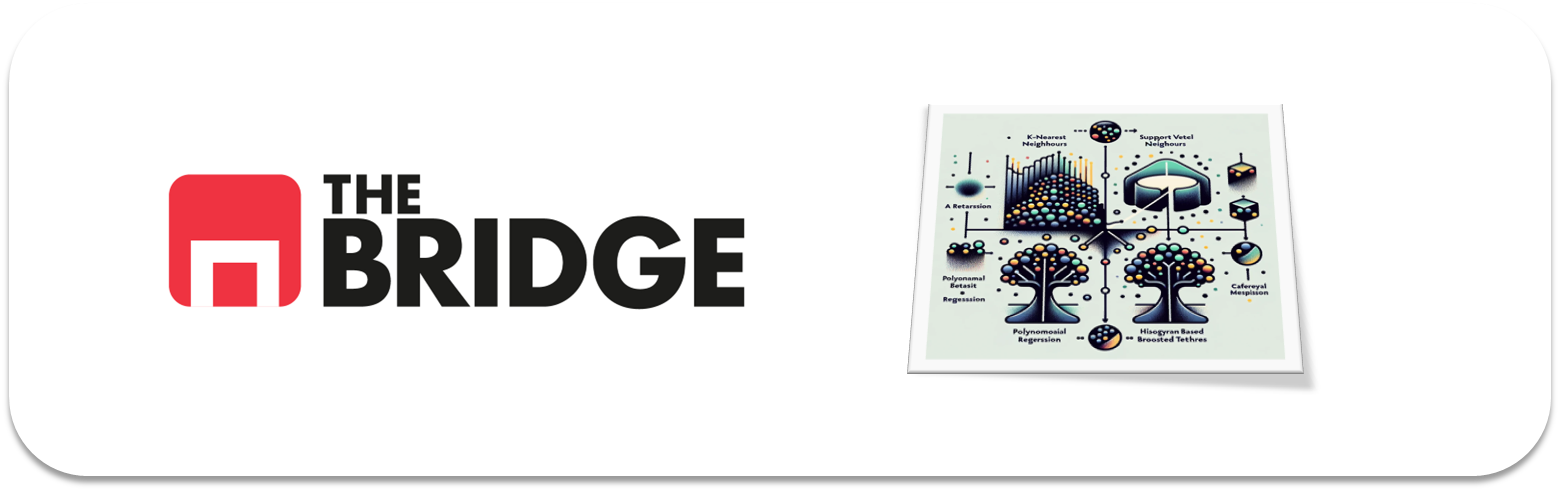

## PRACTICA OBLIGATORIA: **Repaso Aprendizaje Supervisado**

* La práctica obligatoria de esta unidad consiste en resolver sobre un mismo dataset un problema de clasificación y un problema de regresión. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [ ]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, make_scorer, precision_score, ConfusionMatrixDisplay,mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, XGBRegressor

pd.options.mode.copy_on_write = True

In [ ]:
# Función para regresión
def plot_predictions_vs_actual(y_real, y_pred):
    """
    Función para graficar los valores reales vs. los valores predichos en una regresión.

    Args:
    y_real (array-like): Valores reales de la variable objetivo.
    y_pred (array-like): Valores predichos de la variable objetivo.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, y_real, alpha=0.5)
    plt.xlabel("Valores Predichos")
    plt.ylabel("Valores Reales")

    # Línea y=x
    max_value = max(max(y_real), max(y_pred))
    min_value = min(min(y_real), min(y_pred))
    plt.plot([min_value, max_value], [min_value, max_value], 'r')

    plt.title("Comparación de Valores Reales vs. Predichos")
    plt.show()

### #1 Explicación del dataset y carga de datos

Vamos a trabajar con el dataset "Wine Quality", que es un dataset en el que se recogen diversas características fisicoquímicas de las variades tinta y blanca del "Vinho verde" portugués. Las variables del dataset se describen a continuación


1. **Acidez fija**: La mayoría de los ácidos involucrados con el vino son fijos o no volátiles (no se evaporan fácilmente).
2. **Acidez volátil**: La cantidad de ácido acético en el vino, que en niveles demasiado altos puede llevar a un sabor desagradable a vinagre.
3. **Ácido cítrico**: Encontrado en pequeñas cantidades, el ácido cítrico puede añadir 'frescura' y sabor a los vinos.
4. **Azúcar residual**: Es la cantidad de azúcar restante después de que se detiene la fermentación, es raro encontrar vinos con menos de 1 gramo/litro y vinos con más de 45 gramos/litro se consideran dulces.
5. **Cloruros**: La cantidad de sal en el vino.
6. **Dióxido de azufre libre**: La porción libre de SO2 existe en equilibrio entre el SO2 molecular (como un gas disuelto) y el ion bisulfito; previene el crecimiento microbiano y la oxidación del vino.
7. **Dióxido de azufre total**: Es la cantidad de formas libres y ligadas de S02; en bajas concentraciones, el SO2 es en su mayoría indetectable en el vino, pero en concentraciones libres de más de 50 ppm, el SO2 se hace evidente en la nariz y el sabor del vino.
8. **Densidad**: La densidad del vino es cercana a la del agua dependiendo del porcentaje de alcohol y contenido de azúcar.
9. **pH**: Describe qué tan ácido o básico es un vino en una escala de 0 (muy ácido) a 14 (muy básico); la mayoría de los vinos están entre 3-4 en la escala de pH.
10. **Sulfatos**: Un aditivo del vino que puede contribuir a los niveles de dióxido de azufre (SO2), que actúa como un antimicrobiano y antioxidante.
11. **Alcohol**: El porcentaje de contenido de alcohol del vino.
12. **Calidad**: Una variable de salida (basada en datos sensoriales, puntuación entre 0 y 10).
13. **Class**: Si es blanco o tinto.



Carga el dataset **"wines_dataset.csv"**, muestra sus primeras filas, su información general y define dos variables *target*: una para **clasificación**, que permita predecir la **calidad del vino** según el resto de propiedades, y otra para **regresión**, que permita predecir el **grado alcohólico** del vino a partir del resto de propiedades.

El **objetivo de negocio en el primer problema** será anticipar la posible clasificación de sus vinos por parte de los catadores profesionales y, a partir de ahí, poder planificar la producción, la distribución y el precio a asignar a cada vino. En este sentido, el *cliente* nos indica que le gustaría clasificar correctamente lo mejor posible **en media**, lo que interpretamos como maximizar el **recall medio**.

El **objetivo de negocio en el segundo problema** (bastante artificial) es poder realizar simulaciones de posibles vinos futuros para saber cómo conseguir variedades más o menos alcohólicas y así atender mercados diferentes. En este caso, les interesa equivocarse lo menos posible **en términos porcentuales** respecto al grado alcohólico real.

Muestra la **distribución de ambos targets** y realiza una **pequeña evaluación previa** de cada problema.

**Nota:** El dataset está limpio y no contiene valores faltantes.


In [11]:
df = pd.read_csv("./data/wines_dataset.csv", sep = "|")

In [12]:
df.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,class
0,8.5,0.210,0.26,9.25,0.034,73.0,142.0,0.99450,3.05,0.37,11.4,6,white
1,8.3,0.160,0.37,7.90,0.025,38.0,107.0,0.99306,2.93,0.37,11.9,6,white
2,6.8,0.180,0.38,1.40,0.038,35.0,111.0,0.99180,3.32,0.59,11.2,7,white
3,6.1,0.260,0.25,2.90,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,3,white
4,7.5,0.630,0.27,2.00,0.083,17.0,91.0,0.99616,3.26,0.58,9.8,6,red
5,5.7,0.265,0.28,6.90,0.036,46.0,150.0,0.99299,3.36,0.44,10.8,7,white
6,6.6,0.210,0.31,11.40,0.039,46.0,165.0,0.99795,3.41,0.44,9.8,7,white
7,6.7,0.310,0.30,2.10,0.038,18.0,130.0,0.99280,3.36,0.63,10.6,6,white
8,8.9,0.750,0.14,2.50,0.086,9.0,30.0,0.99824,3.34,0.64,10.5,5,red
9,7.5,0.420,0.20,1.40,0.060,15.0,168.0,0.99440,3.06,0.40,9.4,6,white


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  class                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [14]:
target_clf = "quality"
target_reg = "alcohol"

In [80]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [81]:
df.quality.value_counts()

quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64

*Para el caso del target de clasificación:*

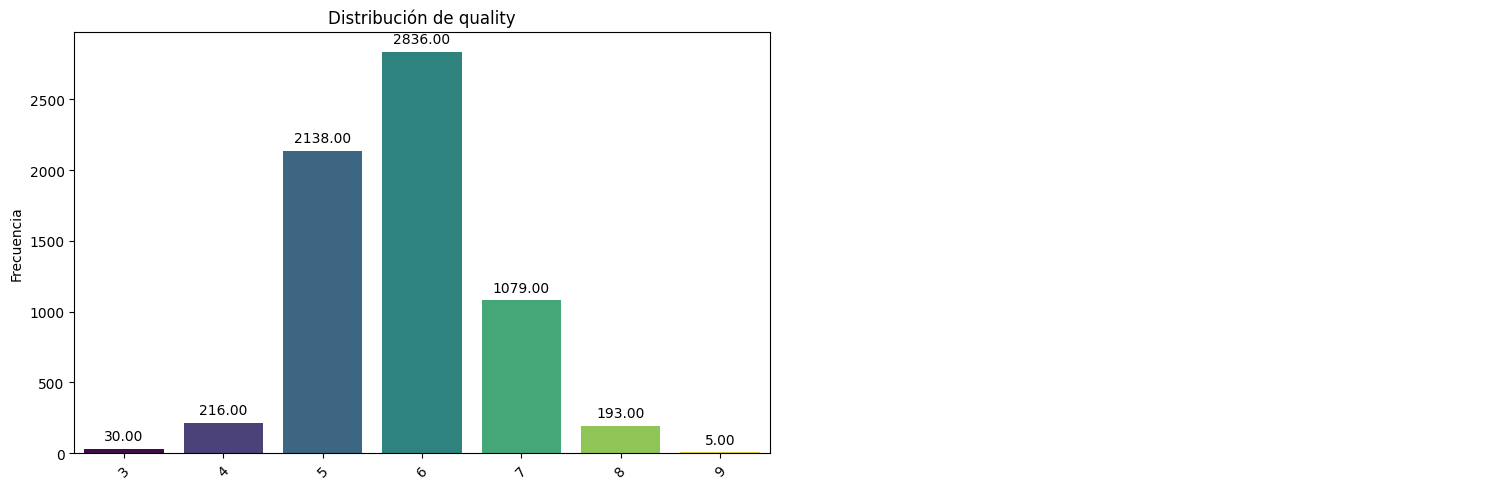

In [88]:
bt.pinta_distribucion_categoricas(df, [target_clf], mostrar_valores = True, relativa = True)

*Se trata de un problema multiclase fuertemente desequilibrado, algo tendremos que hacer con esa situación*

*Para el caso del target de regresión:*

<Axes: xlabel='alcohol', ylabel='Count'>

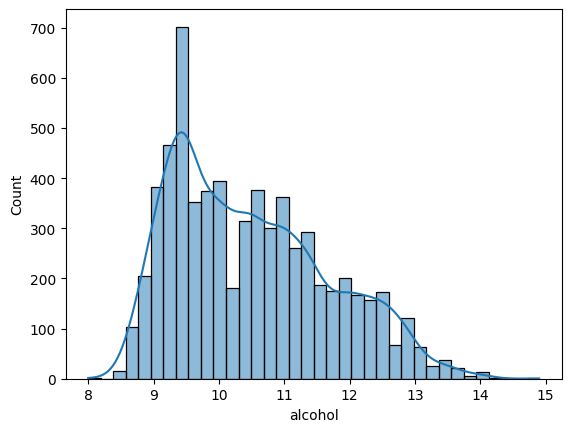

In [16]:
sns.histplot(df[target_reg], kde = True)

*Tiene una distribución que no es exactmente normal pero no tiene mala pinta incluso para una regresión lineal*

### #2 Modelado para clasificación

Crea un modelo que permita clasificar lo mejor posible los vinos en función de su calidad, o dicho de otro modo que prediga de la mejor manera posible la calidad de un vino a partir de sus propiedades químicas. ***Considéralo un problema de clasificación***, donde los valores de calidad son las clases a predecir. Puedes utilizar los modelos que creas conveniente, al menos tres, y utiliza un KNN como modelo baseline, prueba al menos con 2 valores de K. Intenta mejorar el "recall medio" con las técnicas que creas conveniente. Compara los modelos utilizando validación cruzada con o sin optimización previa de hiperparámetros (aunque en la sesión en vivo por limitación de tiempos sólo lo haremos con validación cruzada). El modelo elegido si tiene que tener un ejemplo de optimización de parámetros.

Evalúa el modelo, analiza los errores y propón algún mecanismo de mejora aunque sea sólo un esbozo.

Siguiendo el esquema:

1. Entendimiento del problema (selección de la métrica más adecuada)  
2. Obtención de datos y primer contacto  
3. Train y Test  <- PARTIMOS DE AQUI
4. MiniEDA: Análisis del target, análisis bivariante, entendimiento de las features, selección de las mismas (si es necesario)
    Categoricas -> 0-1 -> MinMax (a,b), con a < b
    Categoricas -> 0 a 10 y numericas -> StandardScaler -> 2 juegos 
5. Preparación del dataset de Train: Conversión de categóricas, tratamiento de numéricas  
6. Selección e instanciación de modelos. Baseline.
7. Comparación de modelos (lo haremos por comparación con validación, puedes hacerlo por comparación de modelos de hiperparámetros optimizados, si así lo prefieres)  TIEMPO es la clave -> 1) Tuneo/Ajusto los hiperparámetros; 2) validación cruzada (set de validación)
8. Selección de modelo: Optimización de hiperparámetros (ten en cuenta la nota de 7) (hiperparametro -> class_weight) 
9. Equilibrado del train set  (Oversampling SMOTE, Undersampling....)
10. Evaluación contra test.  
11. Análisis de errores, posibles acciones futuras.  
12. EXTRA: Persistencia del modelo en disco.  

In [ ]:
# Nos vale para los dos problemas:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 42)

*Para el miniEDA vamos a hacer los dos uno detrás de otro y generaremos las listas de features separadas si es necesario (hay que quitar los targets correspondientes)*

*Partimos de que son todas numéricas excepto class (y quality en el caso del problema de regresión)*

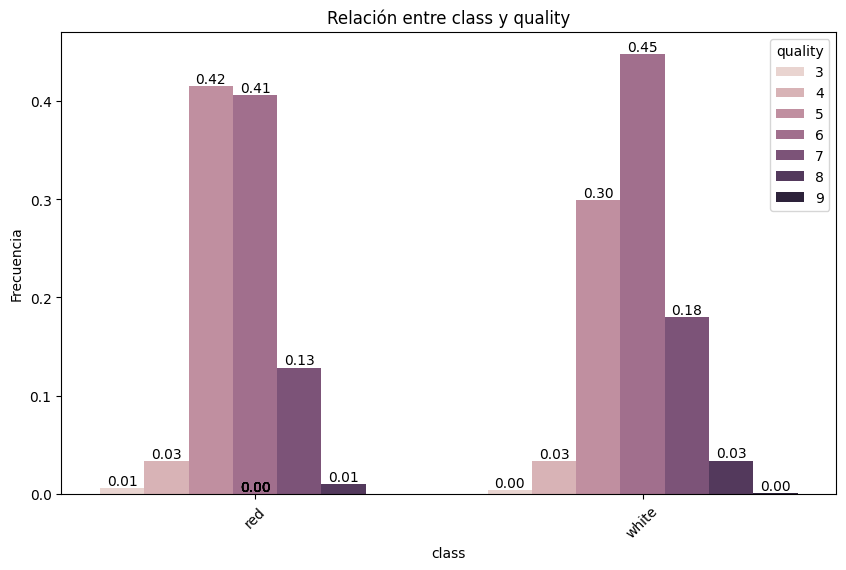

In [18]:
# MiniEDA: Clasificación

# Categóricas 

bt.plot_categorical_relationship_fin(train_set, "class", target_clf, show_values= True, relative_freq= True)


*Hay ligera diferencia (entre 5, 6 y 7) que me invita a quedármela aunque no espero un gran impacto*


In [19]:
features_cat_clf = ["class"]

In [20]:
# Analizamos las numéricas 

features_num_clf = [col for col in train_set.columns if col != "class" and col != target_clf] # Me quedo con todas que no son categóricas, ni el target
print(len(features_num_clf)) # Veo cuantas son para saber qué utilizar si pairplot o las funciones de bt

11


*Utilizando bootcampviztools*

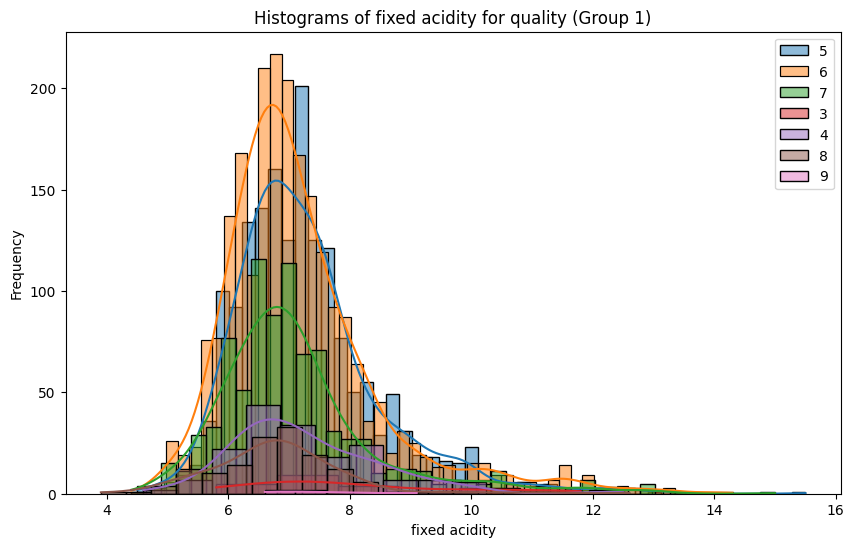

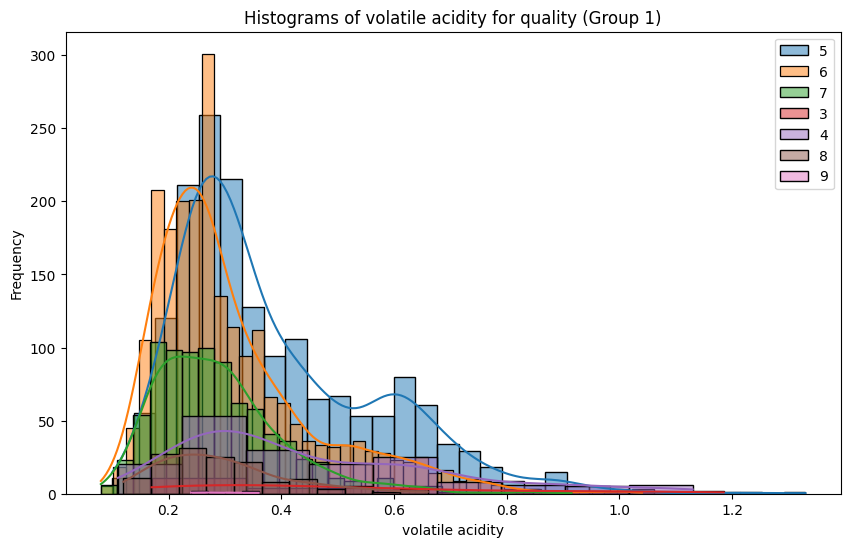

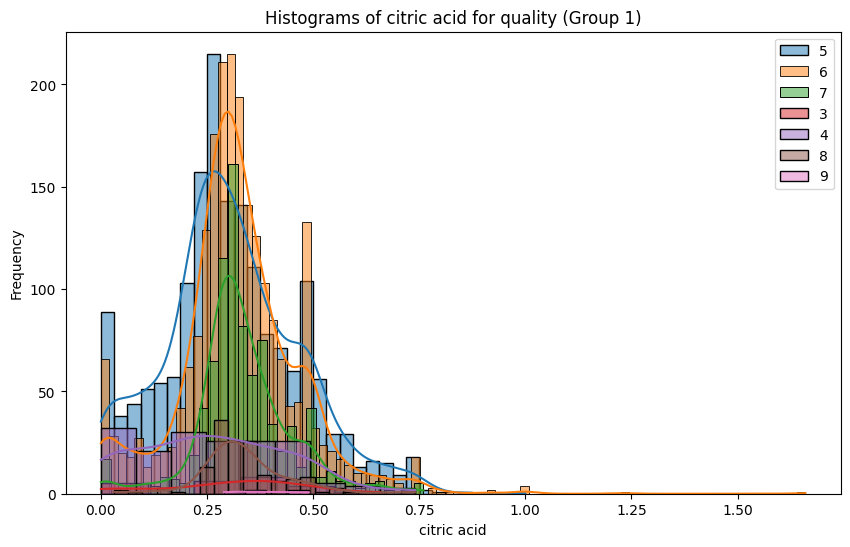

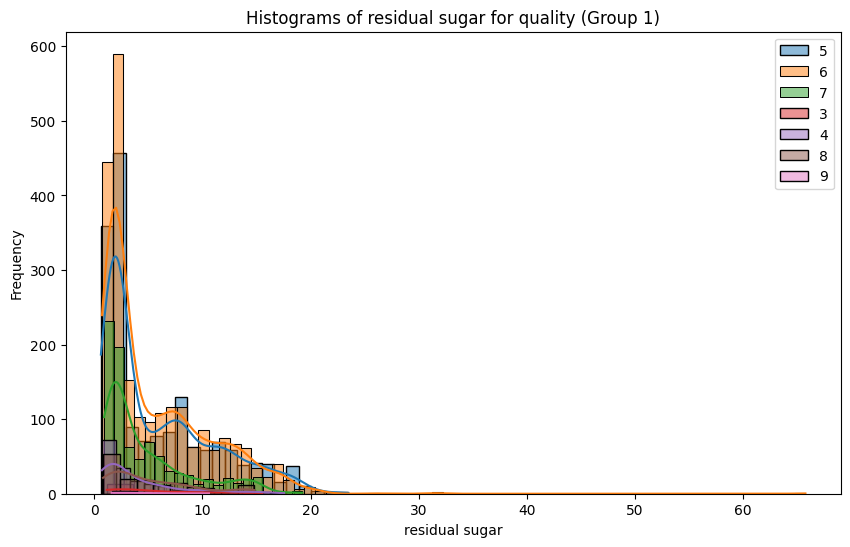

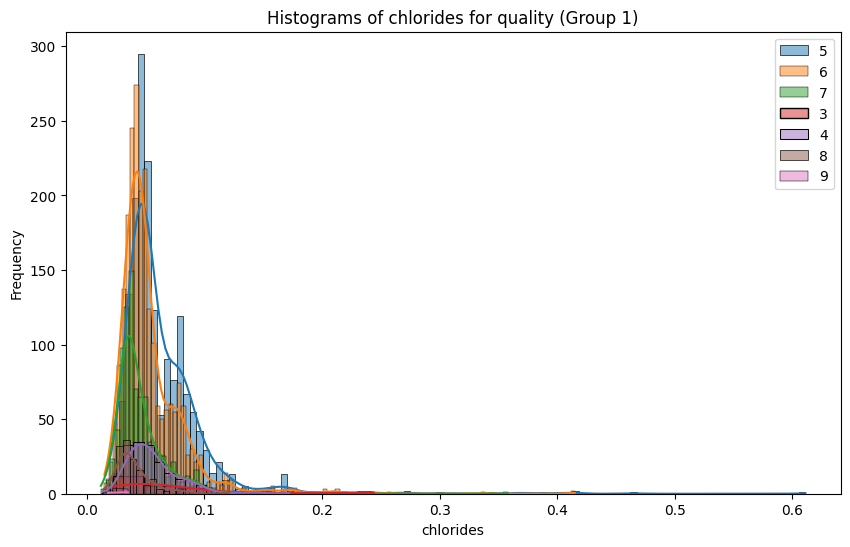

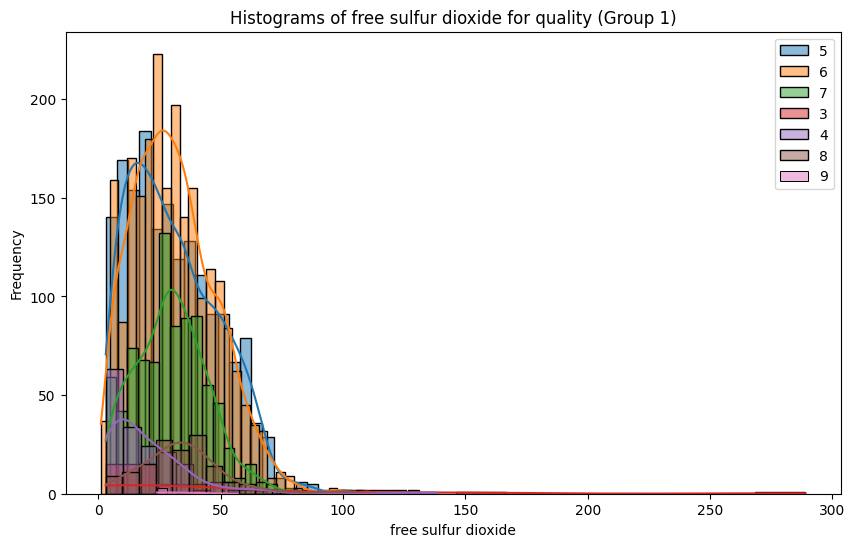

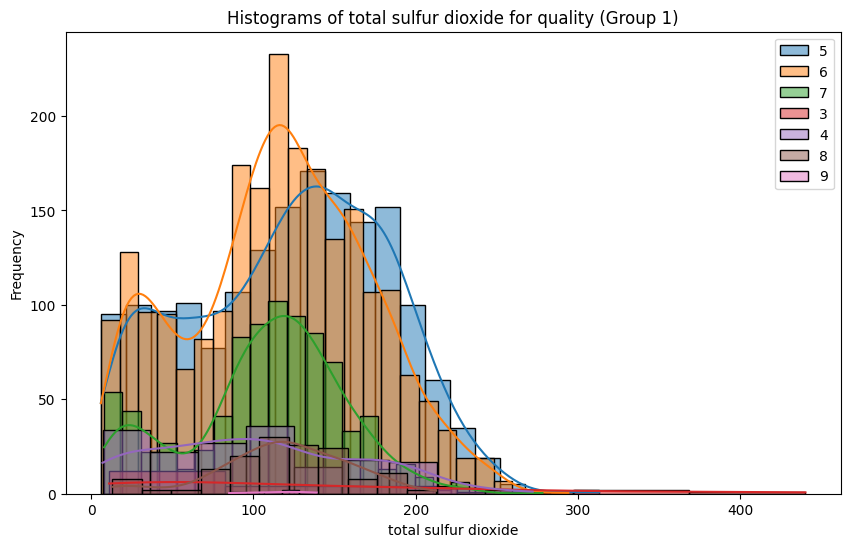

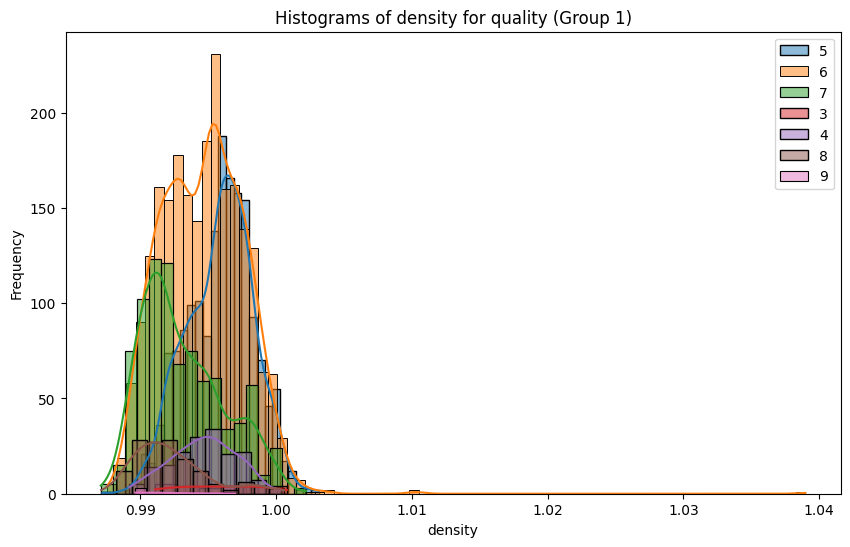

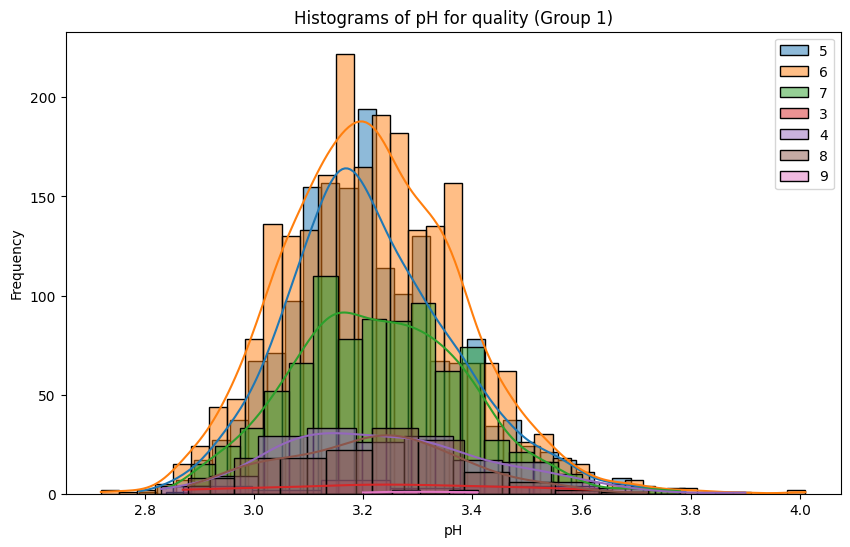

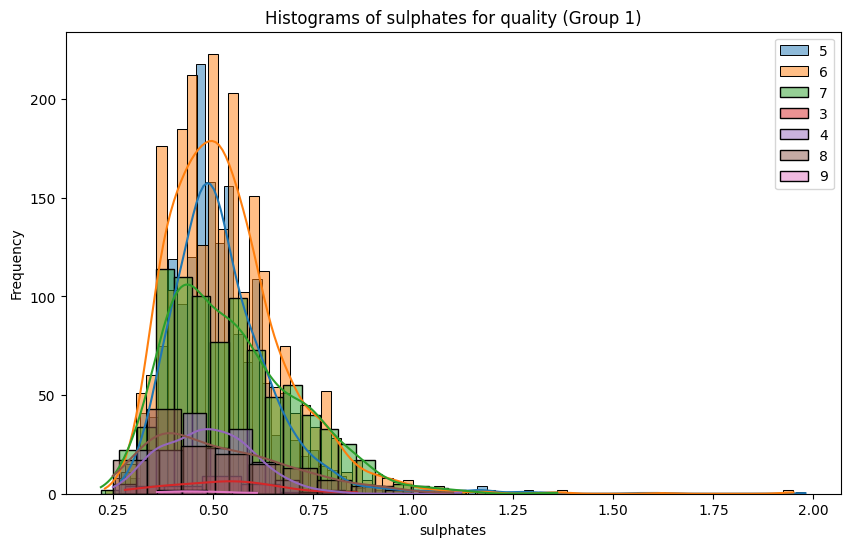

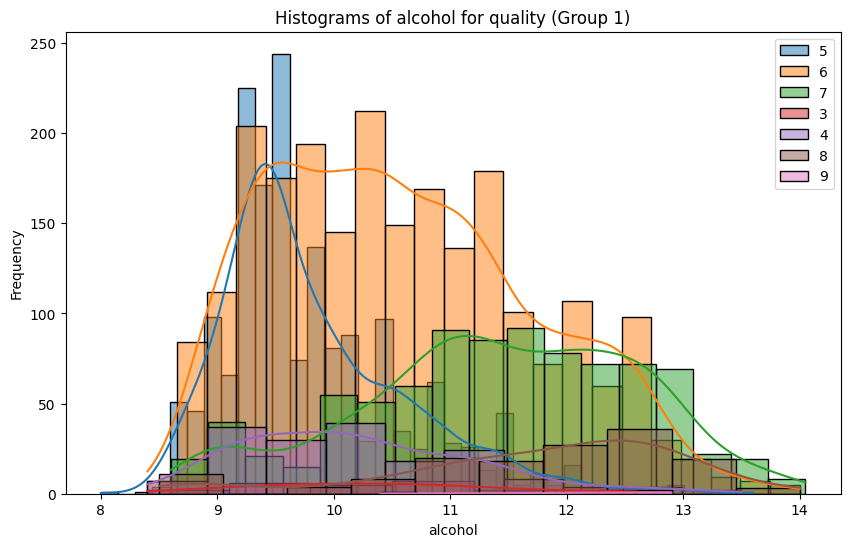

In [21]:
for col in features_num_clf:
    bt.plot_grouped_histograms(train_set, cat_col= target_clf, num_col= col, group_size= train_set[target_clf].nunique())

In [ ]:
# # Alternativa visualización
 
# valores_target = train_set[target_clf].unique().tolist() 

# for col in features_num_clf:
#     plt.figure(figsize=(8, 6))  
#     for i in sorted(valores_target):  
#         sns.kdeplot(
#             train_set[train_set[target_clf] == i][col],
#             fill=True,
#             alpha=0.2,
#             label=f"Clase {i}" 
#         )
#     plt.title(f"Distribuciones de {col}")
#     plt.xlabel(col)
#     plt.ylabel("Densidad")
#     plt.legend(title="Clases")
#     plt.show()

*Analizando una a una:*  

***fixed_acidity***: *En general bastante superposición de todas las distribuciones. ***Secundaria***  
***volatile_acidity***: *Tiene un desplazamiento entre 5 y 6 y varios ligeros desplazamientos del resto. ***Primaria*** aunque sin expectativas*   
***citric_acid*** *: Desplazamiento, ligero pero existente entre casi todas las curvas. ***Primaria*** sin expectativas*  
***residual_sugar*** *: Superposición y alineamiento*. ***Secundaria***  
***Chlorides*** : Cruces y desplazamientos de las densidades e histogramas entre sí. ***Primaria***  
***free_sulfur_dioxide*** *: Desplazamiento de las curvas entre sí y cruces.* ***Primaria***   
***total_sulfur_dioxide*** *: Como la anterior, quizá deberíamos ver si las dos están muy correladas y quitarnos una, mientras tanto ->* ***Primaria***  
***desinty*** *: Desplazamiento de las curvas y cruces.* ***Primaria***  
***pH*** *: Ligeros desplazamientos, no espero mucho pero la incluyo en ***Primaria*** con reservas*  
***sulphates*** *: Superposición para notas bajas desplazamientos para altas. ***Primaria*** con reservas*  
***alcohol*** *: Curvas diferenciadas y algunas claramente separadas.* ***Primaria***  

In [23]:
featues_num_clf_1 = ["volatile acidity","citric acid","chlorides","free sulfur dioxide","total sulfur dioxide", "density","sulphates","alcohol"]
features_num_clf_2 = ["fixed acidity","residual sugar","pH"]

In [24]:
features_cat_clf

['class']

In [25]:
featues_num_clf_1

['volatile acidity',
 'citric acid',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'sulphates',
 'alcohol']

In [26]:
features_num_clf_2

['fixed acidity', 'residual sugar', 'pH']

#### MiniEDA Regresion

In [27]:
features_cat_reg = ["class", "quality"]
features_cat_reg

['class', 'quality']

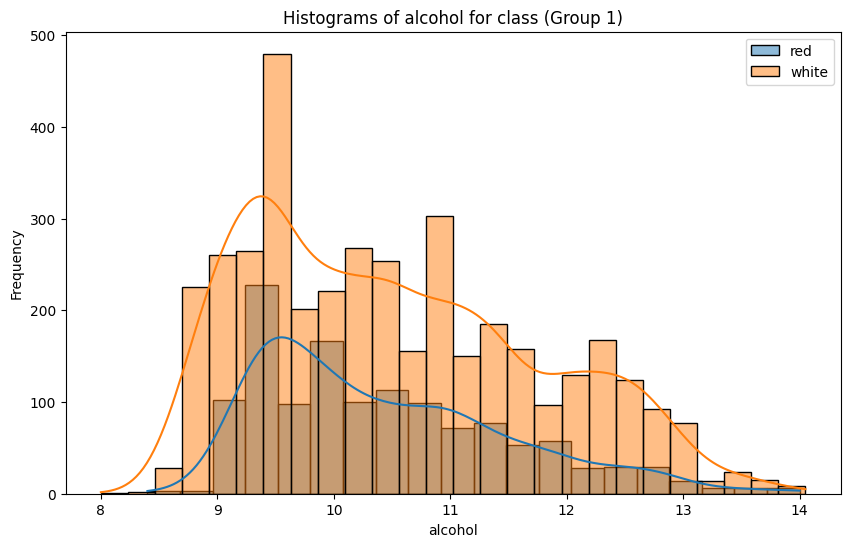

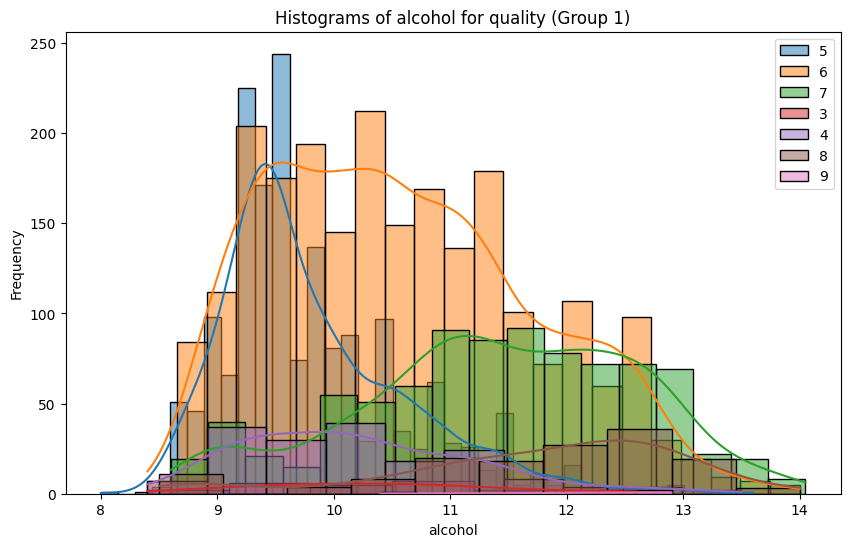

In [28]:
# Categóricas: class y quality

# Quality y alcohol ya la hemos visto antes al estudiar el bivariante del problema de clasificación: es la última gráfica y parece que sí hay relación.

for col in features_cat_reg:
    bt.plot_grouped_histograms(train_set, cat_col= col, num_col= target_reg, group_size= train_set[col].nunique())

*Parece que hay un mínimo de alcohol para el tinto que es mayor que para blanco, nos  quedamos "class" porque los últimos jueces son nuestros modelos.*

In [29]:
features_cat_reg = ["class","quality"]

In [30]:
features_num_reg = [col for col in train_set.columns if col not in features_cat_reg]
features_num_reg

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [31]:
# Estudiamos ahora las correlaciones y el mapa de correlaciones

corr = train_set[features_num_reg].corr(numeric_only= "True")
serie_corr = np.abs(corr[target_reg]).sort_values(ascending = False)
serie_corr

alcohol                 1.000000
density                 0.682345
residual sugar          0.357459
total sulfur dioxide    0.272970
chlorides               0.260508
free sulfur dioxide     0.188460
pH                      0.116497
fixed acidity           0.091964
volatile acidity        0.036041
citric acid             0.005690
sulphates               0.000412
Name: alcohol, dtype: float64

*Nos quedamos con las que tengan r > 0.1, aunque podíamos haber sido más exigentes*

In [32]:
r_min = 0.10

features_num_reg_1 = serie_corr[serie_corr > r_min].index.to_list()
features_num_reg_1.remove(target_reg)

features_num_reg_2 = [col for col in train_set.columns if col not in features_num_reg_1 and col != target_reg
                       and col not in features_cat_reg]

In [33]:
features_num_reg_1

['density',
 'residual sugar',
 'total sulfur dioxide',
 'chlorides',
 'free sulfur dioxide',
 'pH']

<Axes: >

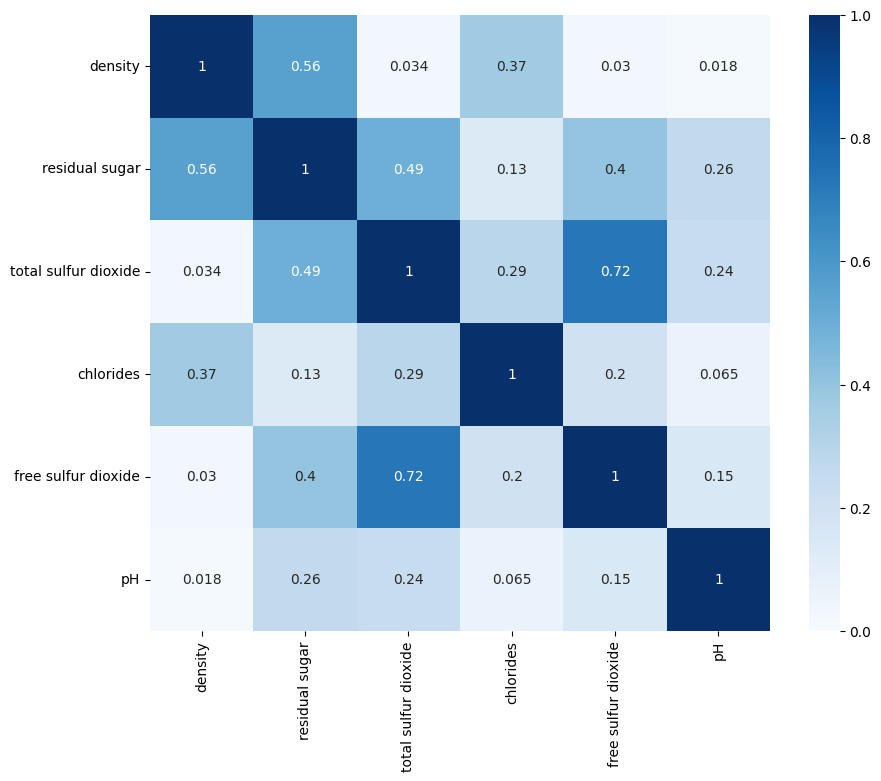

In [34]:
plt.figure(figsize= (10,8))
sns.heatmap(np.abs(train_set[features_num_reg_1].corr(numeric_only= "True")), annot= True, cmap = "Blues", vmin= 0, vmax= 1)

*Aunque hay alguna correlación relativamente significativa entre las features numéricas (residual sugar y density), la que más destaca como era de esperar es la de free sulfur dioxide y total sulfur dioxide. Podemos quedarnos con una y probar a deja la otra fuera*


In [35]:
features_num_reg_1.remove("free sulfur dioxide") # Es la que menos correla con alcohol.
features_num_reg_2.append("free sulfur dioxide")

In [90]:
print(features_num_reg_1)
print(features_num_reg_2)

['density', 'residual sugar', 'total sulfur dioxide', 'chlorides', 'pH']
['fixed acidity', 'volatile acidity', 'citric acid', 'sulphates', 'free sulfur dioxide']


*Tratamos ahora las features (necesitamos escalar porque vamos a emplear un KNN y además tenemos que convertir las categóricas)*

In [36]:
pd.get_dummies(train_set["class"], columns="class", drop_first=True, dtype=int)

,white
1916,0
947,1
877,1
2927,1
6063,0
...,...
3772,1
5191,1
5226,1
5390,1


In [37]:
train_set["class"] = (train_set["class"] == "white").astype(int) # white -> clase 1, red -> clase 0
test_set["class"] = (test_set["class"] == "white").astype(int) # white -> clase 1, red -> clase 0

In [38]:
# Dejamos "quality" y "alcohol" para el final porque son los dos targets, tendremos que procesar en una si y en otra no

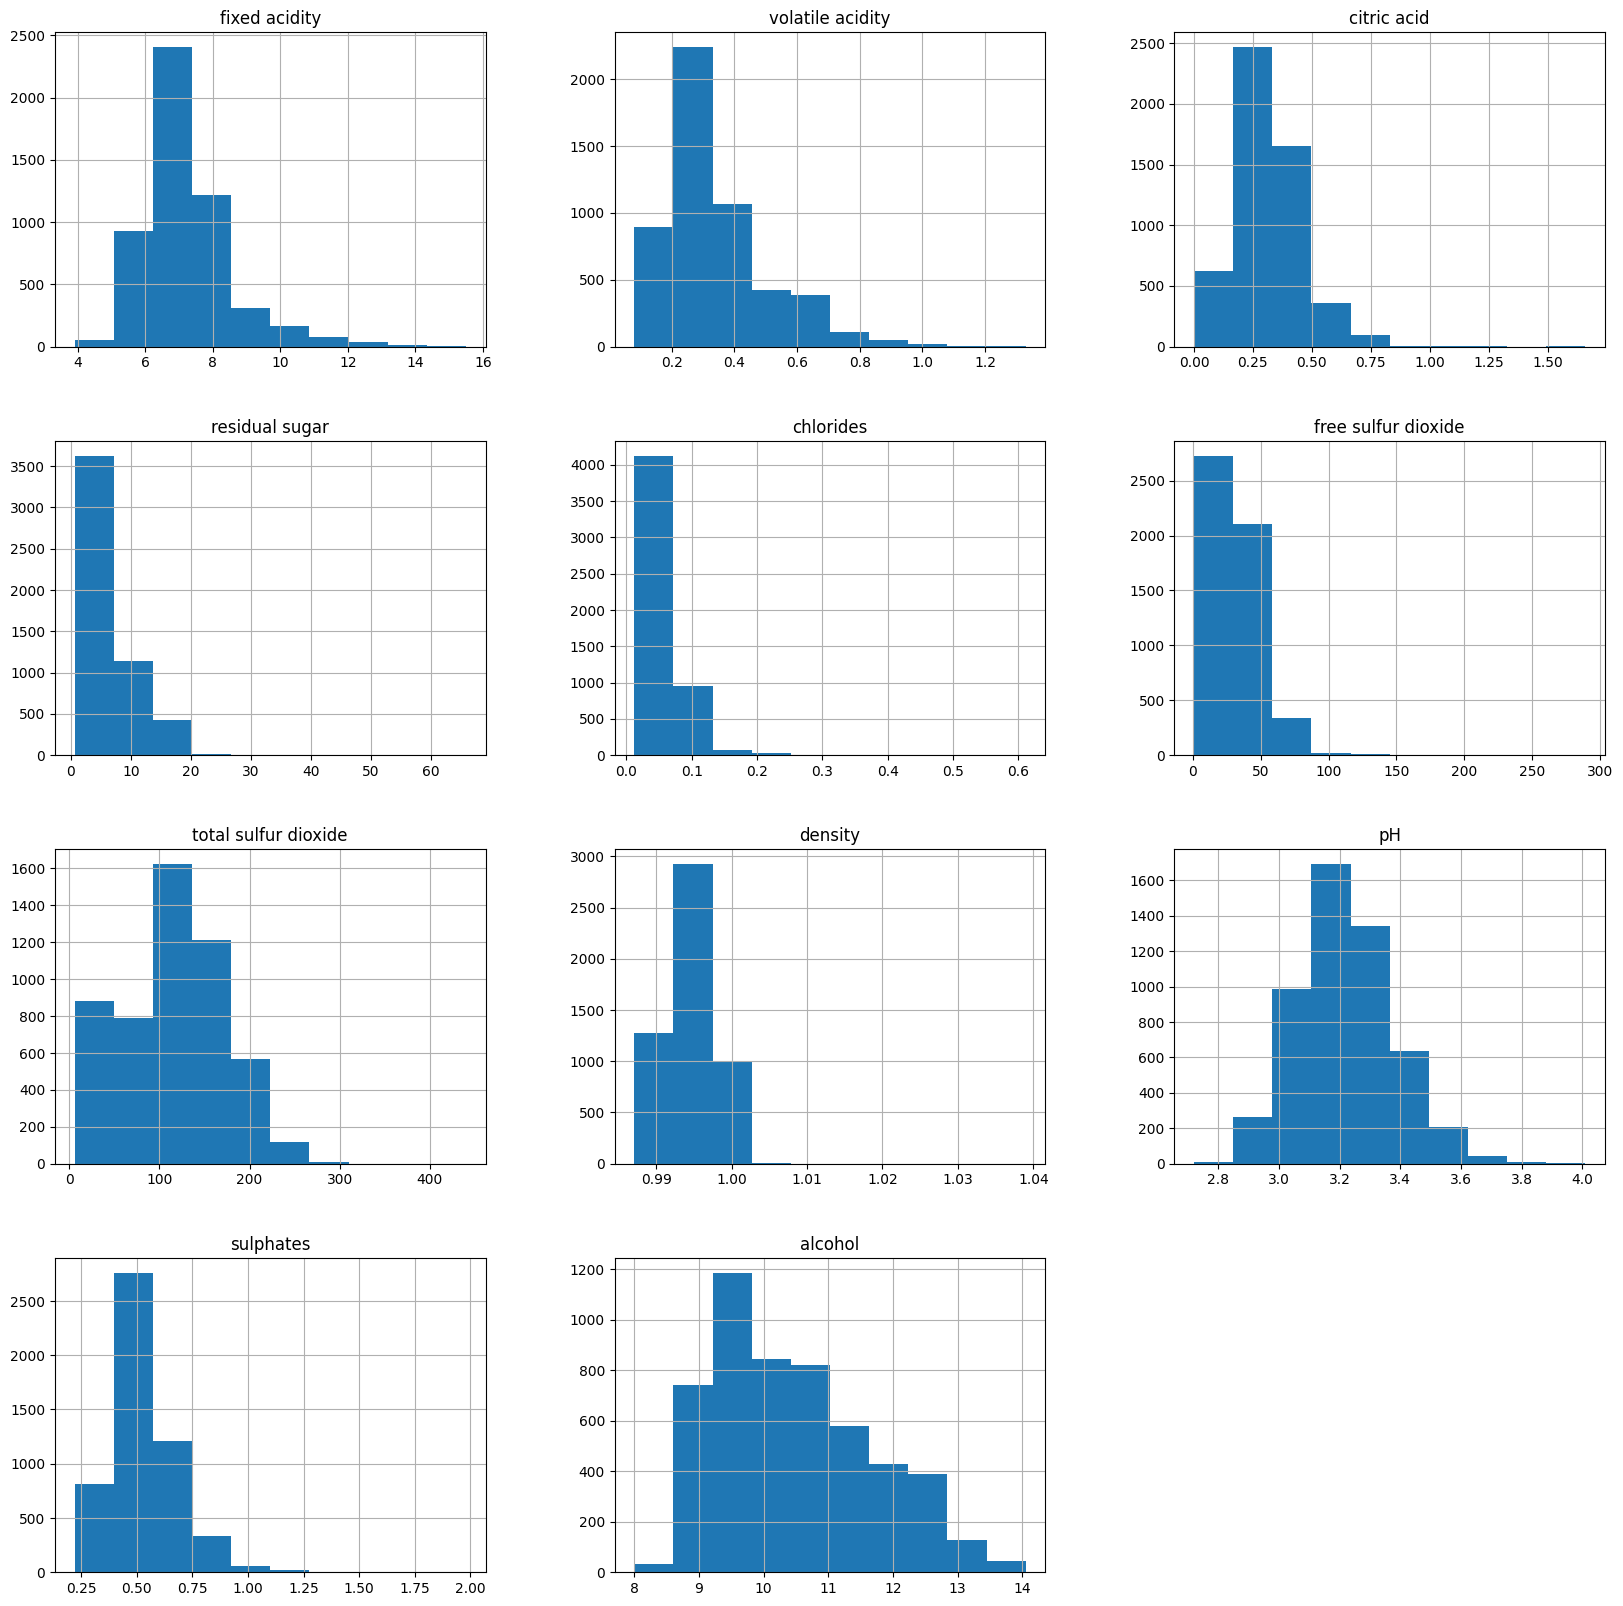

In [39]:
train_set[features_num_clf].hist(figsize = (20,20))
plt.tight_layout
plt.show()

In [40]:
# # Opción para visualizar el resultado de aplicar log10 o sqrt a las features :)

# fig, ax = plt.subplots(len(features_num_clf),3, figsize=(20,50))

# for index, feature in enumerate(features_num_clf):
# # Aplicamos raíz cuadrada a las features ya que algunas tienen valor 0 como mínimo 
#     log_feature = np.log1p(train_set[feature])
#     sqrt_feature = np.sqrt(train_set[feature])
#     sns.histplot(train_set, x=feature, hue='class', bins=50, kde=True, ax=ax[index, 0])
#     sns.histplot(train_set, x=log_feature, hue='class', bins=50, kde=True, ax=ax[index, 1])
#     sns.histplot(train_set, x=sqrt_feature, hue='class', bins=50, kde=True, ax=ax[index, 2])
#     ax[index, 0].set_xlabel('')
#     ax[index, 1].set_xlabel('')
#     ax[index, 2].set_xlabel('')
#     ax[index, 0].set_ylabel(feature)
#     ax[index, 1].set_ylabel('')
#     ax[index, 2].set_ylabel('')
# plt.tight_layout();

In [41]:
np.log1p(train_set["citric acid"])

1916    0.336472
947     0.553885
877     0.215111
2927    0.246860
6063    0.343590
          ...   
3772    0.405465
5191    0.246860
5226    0.322083
5390    0.254642
860     0.246860
Name: citric acid, Length: 5197, dtype: float64

<Axes: xlabel='alcohol', ylabel='Count'>

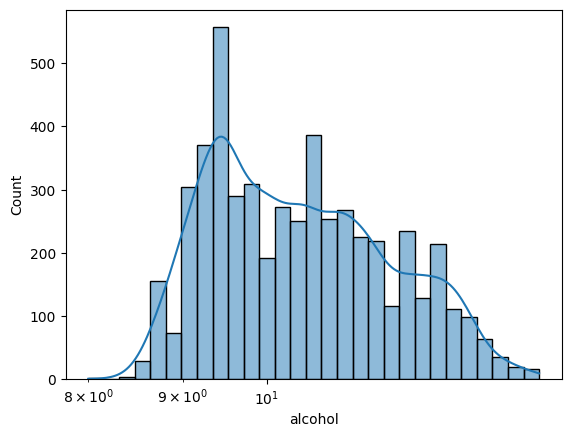

In [42]:
sns.histplot(train_set["alcohol"], kde=True, log_scale=10)

In [43]:
train_set_scaled = train_set.copy()
test_set_scaled = test_set.copy()

In [44]:
features_to_transform = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar", 
    "chlorides",
    "free sulfur dioxide", 
    "total sulfur dioxide",
    "sulphates"
    ]

In [ ]:
# Aplica una transformación logarítmica a las columnas seleccionadas,
# desplazando los valores si es necesario para evitar log(0) o log de negativos
for col in features_to_transform:
    desplaza = 0
    if train_set_scaled[col].min() <= 0:
        desplaza = int(abs(train_set_scaled[col].min())) + 1
    train_set_scaled[col] = np.log(train_set_scaled[col] + desplaza)
    test_set_scaled[col] = np.log(test_set_scaled[col] + desplaza)

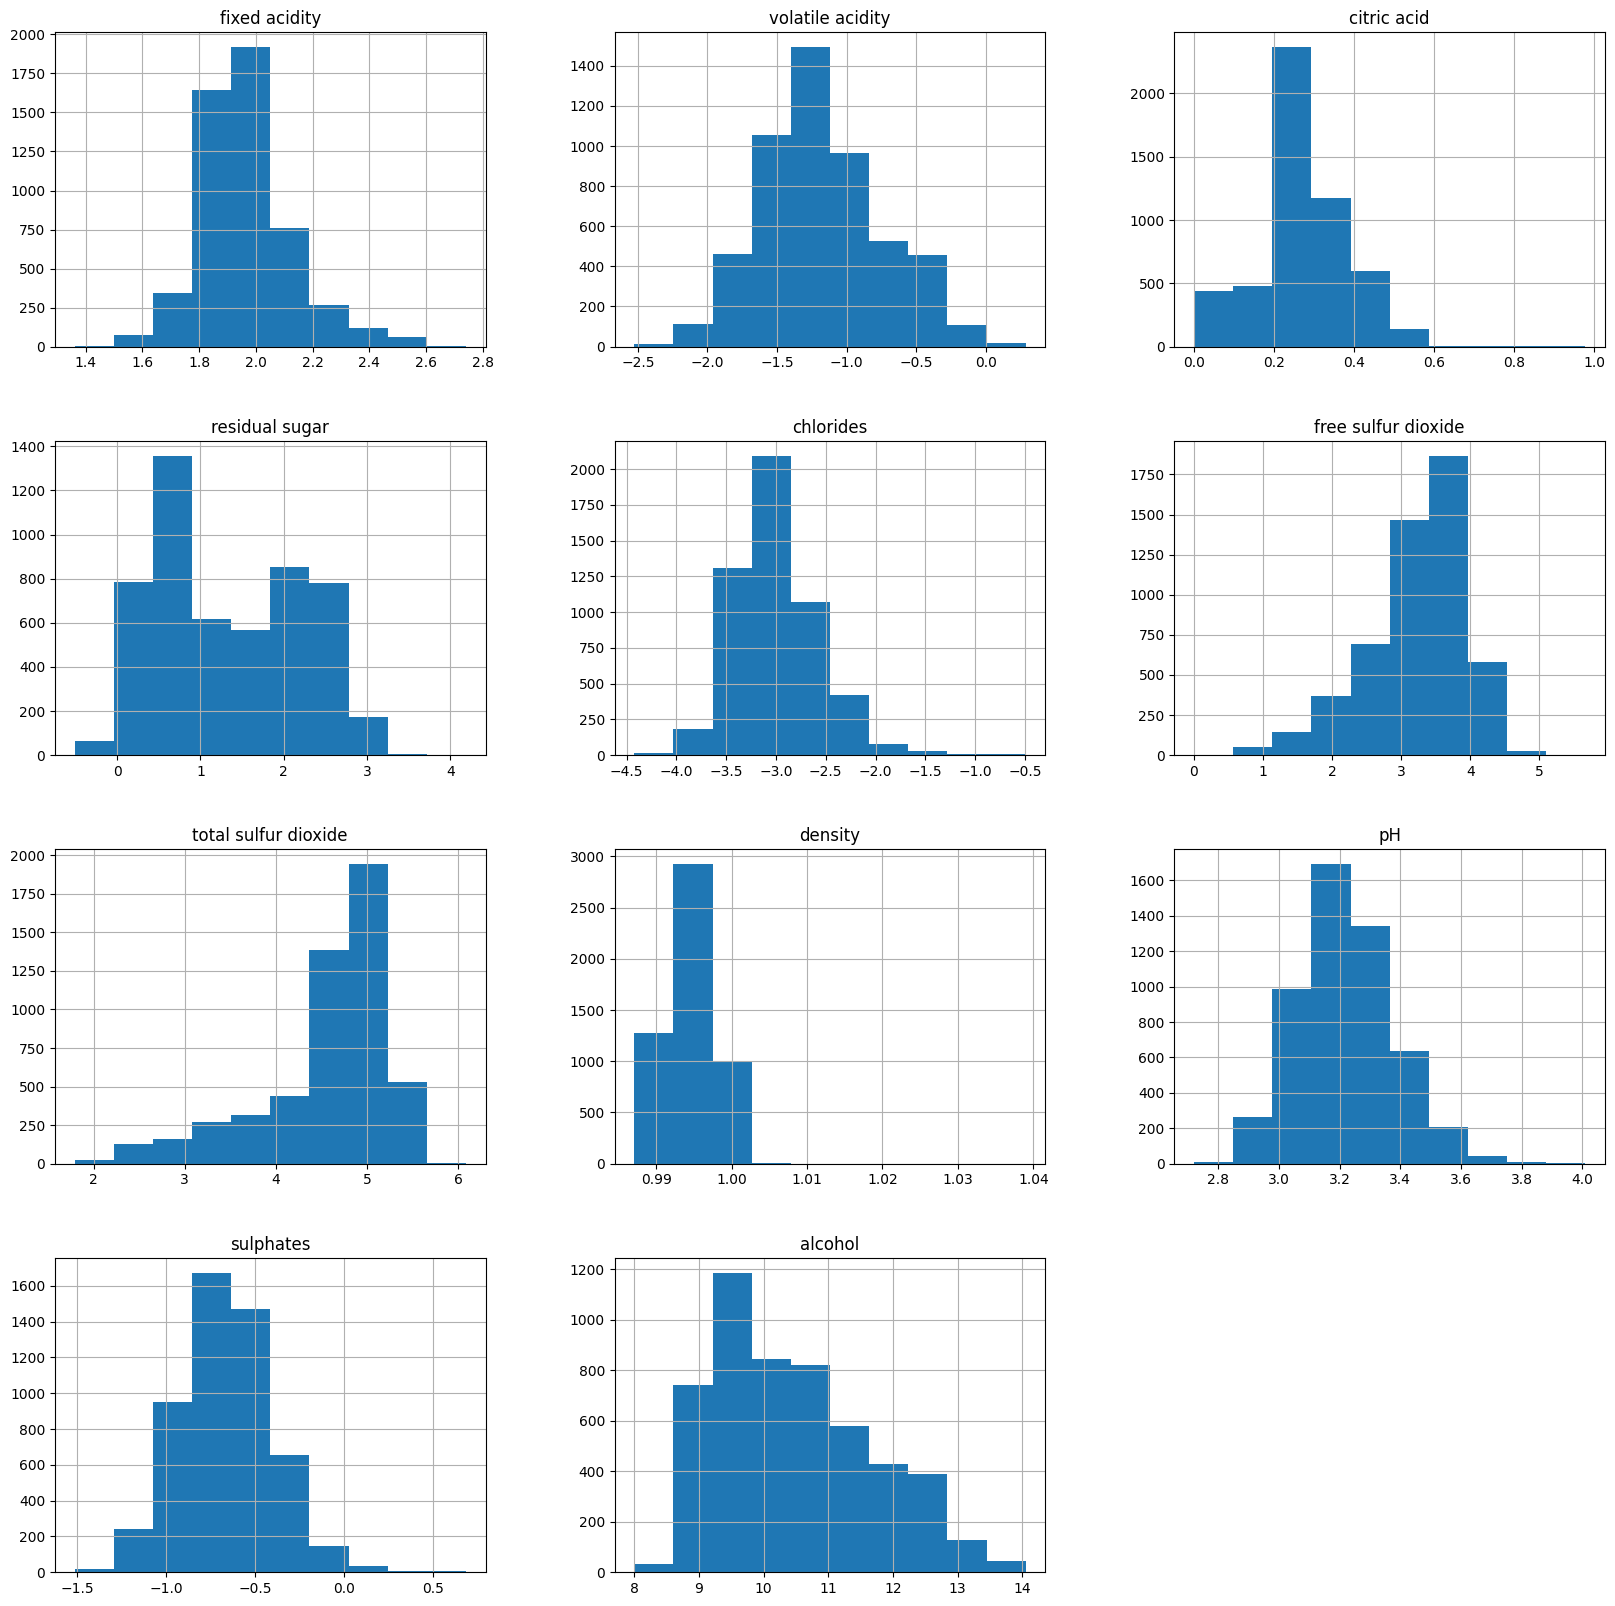

In [46]:
train_set_scaled[features_num_clf].hist(figsize = (20,20))
plt.tight_layout
plt.show()

*En features_num_clf están todas las numéricas, así que me ahorra tener que tratarlas por separado, luego sí que las seleccionaremos por separado. Pero ya separando para regresion y para clasificacion*

In [47]:
features_num_clf

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [48]:
scaler = StandardScaler()

features_num_reg = features_num_clf.copy()
features_num_reg.remove("alcohol") # Alcohol es nuestro target

train_set_scaled[features_num_reg] = scaler.fit_transform(train_set_scaled[features_num_reg])
test_set_scaled[features_num_reg] = scaler.transform(test_set_scaled[features_num_reg])


In [49]:
train_set_scaled[features_num_reg].describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates
count,5.197000e+03,5.197000e+03,5.197000e+03,5.197000e+03,5.197000e+03,5.197000e+03,5.197000e+03,5.197000e+03,5.197000e+03,5.197000e+03
mean,-5.605590e-16,-2.214892e-16,7.656416e-17,2.734434e-18,5.714968e-16,-1.709021e-16,1.668005e-16,5.706764e-14,2.365286e-16,-8.169122e-17
std,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00
min,-3.650546e+00,-3.093987e+00,-2.452808e+00,-2.130418e+00,-3.375535e+00,-4.578518e+00,-3.851433e+00,-2.524538e+00,-3.119464e+00,-3.303529e+00
25%,-6.406275e-01,-6.678919e-01,-4.329462e-01,-8.590345e-01,-6.595501e-01,-5.432713e-01,-3.193079e-01,-7.815705e-01,-6.821081e-01,-6.902881e-01
50%,-9.608146e-02,-1.353685e-01,-8.563028e-03,-2.678746e-01,-1.587052e-01,2.174037e-01,2.927357e-01,6.169387e-02,-5.714499e-02,-2.494373e-02
75%,4.830897e-01,6.034131e-01,5.928880e-01,8.815795e-01,6.052801e-01,7.105928e-01,6.811085e-01,7.588809e-01,6.303145e-01,6.087895e-01
max,4.734467e+00,3.363578e+00,6.402853e+00,3.305764e+00,5.884922e+00,3.491975e+00,2.123631e+00,1.469598e+01,4.942560e+00,5.264422e+00


*Separamos*

In [50]:
train_set_scaled_clf = train_set_scaled.copy()
test_set_scaled_clf = test_set_scaled.copy()

train_set_scaled_clf["alcohol"] = scaler.fit_transform(train_set_scaled_clf[["alcohol"]])
test_set_scaled_clf["alcohol"] = scaler.transform(test_set_scaled_clf[["alcohol"]])

*No, no nos hemos olvidado de quality pero ya está convertida a ordinal como numérica discreta que es con rango limitado o pequeño de valores*

*Creamos X,y variados*

In [51]:
# Clasificación
y_train_clf = train_set[target_clf]
y_test_clf = test_set[target_clf]

#Regresión
y_train_reg = train_set[target_reg]
y_test_reg = test_set[target_reg]

# clasificación
X_train_clf_dict = {}
X_test_clf_dict = {}

#Regresión
X_train_reg_dict = {}
X_test_reg_dict = {}

# Juegos X_train clasificacion

features_set_name = ["cat+num_1", "todas"]
features_set = [features_cat_clf + featues_num_clf_1,
                features_cat_clf + featues_num_clf_1 + features_num_clf_2]


for set_name,feature_list in zip(features_set_name, features_set):
    print(feature_list)
    X_train_clf_dict[set_name] = train_set_scaled_clf[feature_list]
    X_test_clf_dict[set_name] = test_set_scaled_clf[feature_list]

## ----------------------------------- ##
# Juegos X_train regresion
    
features_set_name = ["cat+num_1","todas"]
features_set = [features_cat_reg + features_num_reg_1,
                features_cat_reg + features_num_reg_1 + features_num_reg_2]

for set_name,feature_list in zip(features_set_name, features_set):
    print(feature_list)
    X_train_reg_dict[set_name] = train_set_scaled[feature_list]
    X_test_reg_dict[set_name] = test_set_scaled[feature_list]

['class', 'volatile acidity', 'citric acid', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'sulphates', 'alcohol']
['class', 'volatile acidity', 'citric acid', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'sulphates', 'alcohol', 'fixed acidity', 'residual sugar', 'pH']
['class', 'quality', 'density', 'residual sugar', 'total sulfur dioxide', 'chlorides', 'pH']
['class', 'quality', 'density', 'residual sugar', 'total sulfur dioxide', 'chlorides', 'pH', 'fixed acidity', 'volatile acidity', 'citric acid', 'sulphates', 'free sulfur dioxide']


*Ya lo que queda de sección nos centramos en clasificación*

In [ ]:
# Instanciamos modelos
knn_clf = KNeighborsClassifier(n_neighbors= 5)
knn_ten_clf = KNeighborsClassifier(n_neighbors= 10)
lr_clf = LogisticRegression(max_iter = 1000)
rf_clf = RandomForestClassifier(max_depth = 10, random_state= 42)
lgb_clf = LGBMClassifier(max_depth = 10, random_state = 42, verbose = -1, n_jobs= -1)

modelos_clf = {
    "KNN_5": knn_clf,
    "KNN_10": knn_ten_clf,
    "Regresion Logistica": lr_clf,
    "Random Forest": rf_clf,
    "LightGBM": lgb_clf
}

In [53]:
for feature_set, X_train in X_train_clf_dict.items():
    print(f"Para el set {feature_set}:")
    for tipo,modelo in modelos_clf.items():
        print(f"{tipo}: ", end = " ")
        print(np.mean(cross_val_score(modelo, X_train, y_train_clf, cv = 5, scoring = "balanced_accuracy"))) 
    print("******")

Para el set cat+num_1:
KNN_5:  0.2656152390156306
KNN_10:  0.24473064132531913
Regresion Logistica:  0.22461810478576155
Random Forest:  0.2738181185046397
LightGBM:  0.33312050630396667
******
Para el set todas:
KNN_5:  0.2626256925203968
KNN_10:  0.24377920201901465
Regresion Logistica:  0.2277512422678234
Random Forest:  0.27464335447341287
LightGBM:  0.3371484312539852
******


*Los valores son realmente flojos, pero es debido al fuerte desequilibrio que hay entre clases, deberíamos hacer un equilibrado, pero que en nuestro caso se va a centrar por tiempo disponible en usar el parámetro class_weights y el más o menos equivalente de weights en KNN*

In [ ]:
# "hiperparámetro de class_weight para XGBoost"

#from sklearn.utils.class_weight import compute_sample_weight
#sample_weight = compute_sample_weight(class_weight="balanced", y=y_train_xgb1)

#xgb_clf = xgboost.XGBClassifier(max_depth = 5, random_state = 42)
#print(np.mean(model_selection.cross_val_score(xgb_clf, X_train1, y_train_xgb1, scoring='balanced_accuracy', fit_params={"sample_weight": sample_weight})))

In [ ]:
# Instanciamos modelos
knn_clf = KNeighborsClassifier(n_neighbors= 5, weights= "distance")
knn_ten_clf = KNeighborsClassifier(n_neighbors= 10, weights = "distance")
lr_clf = LogisticRegression(max_iter = 1000, class_weight = "balanced")
rf_clf = RandomForestClassifier(max_depth = 10, random_state= 42, class_weight = "balanced")
lgb_clf = LGBMClassifier(max_depth = 10, random_state = 42, verbose = -1, class_weight = "balanced", n_jobs=-1)

modelos_clf = {
    "KNN_5": knn_clf,
    "KNN_10": knn_ten_clf,
    "Regresion Logistica": lr_clf,
    "Random Forest": rf_clf,
    "LightGBM": lgb_clf
}

In [55]:
for feature_set, X_train in X_train_clf_dict.items():
    print(f"Para el set {feature_set}:")
    for tipo,modelo in modelos_clf.items():
        print(f"{tipo}: ", end = " ")
        print(np.mean(cross_val_score(modelo, X_train, y_train_clf, cv = 5, scoring = "balanced_accuracy")))
    print("******")

Para el set cat+num_1:
KNN_5:  0.3438180414446099
KNN_10:  0.3332100205551276
Regresion Logistica:  0.28995872116553434
Random Forest:  0.3544769911973666
LightGBM:  0.3560814306068496
******
Para el set todas:
KNN_5:  0.3423482427183459
KNN_10:  0.3362180100381279
Regresion Logistica:  0.3845352978775572
Random Forest:  0.34149748580207673
LightGBM:  0.35958149480776325
******


*Todos los modelos han mejorado, e incluso podríamos quedarnos con la regresión logistica, pero vamos a hacerlo con LightGBM que parece más consistente en todas las pruebas y también permite a titulo ilustrativo más juego en el aspecto de hiperparámetros*

In [56]:
param_grid = {
    "n_estimators": [100,200,1000],
    "max_depth": [1,5,10,20],
    "learning_rate": [0.1,0.3,0.6,1,0.01],
    "class_weight": ["balanced"]
}

lgb_clf = LGBMClassifier(verbose = -1, n_jobs= -1)

lgb_grid = GridSearchCV(lgb_clf,
                        param_grid= param_grid,
                        cv = 5,
                        scoring = "balanced_accuracy")

lgb_grid.fit(X_train_clf_dict["todas"], y_train_clf)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","LGBMClassifie...1, verbose=-1)"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'class_weight': ['balanced'], 'learning_rate': [0.1, 0.3, ...], 'max_depth': [1, 5, ...], 'n_estimators': [100, 200, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'balanced_accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each

In [57]:
print(lgb_grid.best_params_)
print(lgb_grid.best_score_)

{'class_weight': 'balanced', 'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 200}
0.37134629750829734


In [58]:
print(lgb_grid.get_params()) # Nos ofrece los parametros de GridSearch, no los del modelo evaluado

{'cv': 5, 'error_score': nan, 'estimator__boosting_type': 'gbdt', 'estimator__class_weight': None, 'estimator__colsample_bytree': 1.0, 'estimator__importance_type': 'split', 'estimator__learning_rate': 0.1, 'estimator__max_depth': -1, 'estimator__min_child_samples': 20, 'estimator__min_child_weight': 0.001, 'estimator__min_split_gain': 0.0, 'estimator__n_estimators': 100, 'estimator__n_jobs': -1, 'estimator__num_leaves': 31, 'estimator__objective': None, 'estimator__random_state': None, 'estimator__reg_alpha': 0.0, 'estimator__reg_lambda': 0.0, 'estimator__subsample': 1.0, 'estimator__subsample_for_bin': 200000, 'estimator__subsample_freq': 0, 'estimator__verbose': -1, 'estimator': LGBMClassifier(n_jobs=-1, verbose=-1), 'n_jobs': None, 'param_grid': {'n_estimators': [100, 200, 1000], 'max_depth': [1, 5, 10, 20], 'learning_rate': [0.1, 0.3, 0.6, 1, 0.01], 'class_weight': ['balanced']}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'balanced_accuracy'

In [59]:
lgb_grid.best_estimator_

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,20
,learning_rate,0.01
,n_estimators,200
,subsample_for_bin,200000
,objective,None
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [60]:
# best_params = lgb_grid.best_params_
# best_params

In [ ]:
# Para utilizar en el reentreno

# lgb_clf = LGBMClassifier(**best_params,
#                          verbose = -1,
#                          n_jobs=-1)

Feature importances del LightGBM

In [62]:
lgb_grid.best_estimator_.feature_importances_

array([ 141, 3964, 2355, 4068, 4854, 4094, 3178, 3653, 4552, 3949, 3891,
       3283], dtype=int32)

¿Qué significan estos números? ¿Dónde están los floats con el porcentaje del feature importance?  

En el caso del LightGBM disponemos de su propia función para imprimir los dos tipos de importancia disponibles.

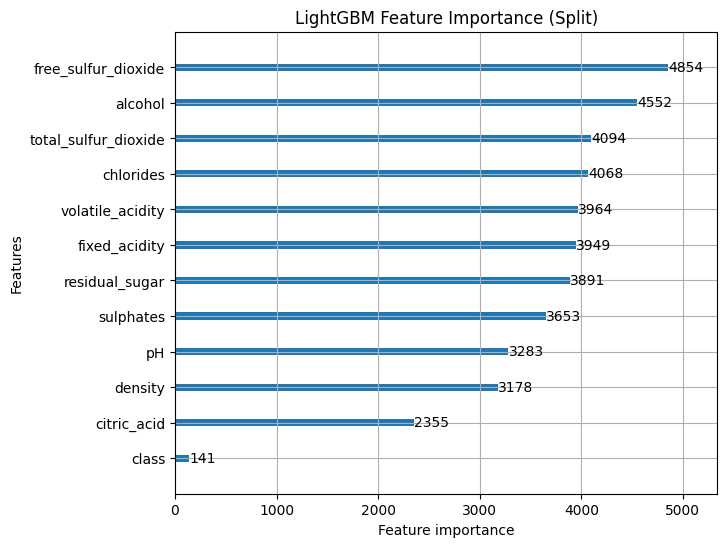

In [63]:
from lightgbm import plot_importance

# Genera un gráfico de importancia de características usando el modelo LightGBM entrenado.
# importance_type="split": cuenta cuántas veces se ha utilizado cada feature para dividir los nodos de los árboles.
# Esto nos indica qué variables son más relevantes para la predicción, aunque no nos dice cuánto mejoran la predicción.

plot_importance(lgb_grid.best_estimator_,
                importance_type="split",
                figsize=(7,6),
                title="LightGBM Feature Importance (Split)")
plt.show()

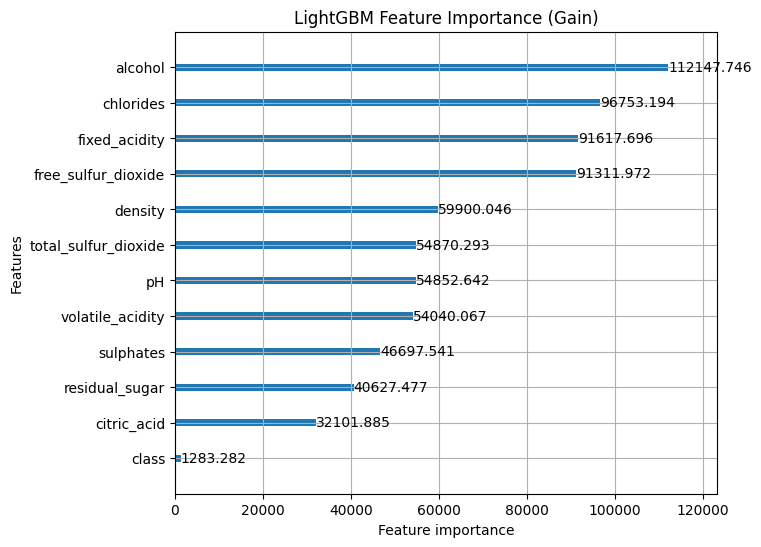

In [64]:
# importance_type="gain": calcula cuánto mejora la función objetivo cada feature cuando se usa para dividir nodos.
# Esto nos indica qué variables contribuyen más a mejorar la precisión del modelo.

plot_importance(lgb_grid.best_estimator_,
                importance_type="gain",
                figsize=(7,6),
                title="LightGBM Feature Importance (Gain)")
plt.show()

Pregunta, ¿la importancia que ha dado el modelo a las features coincide con nuestra previsión inicial?  

#### *Evaluamos contra test y veamos la matriz de confusión para entender los errores*

In [87]:
y_pred = lgb_grid.best_estimator_.predict(X_test_clf_dict["todas"])
# print(classification_report(y_test_clf, y_pred))
print(classification_report(y_test_clf, y_pred, zero_division= 0.0)) # Sin warnings

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.16      0.37      0.23        43
           5       0.62      0.62      0.62       432
           6       0.64      0.39      0.48       562
           7       0.40      0.65      0.50       210
           8       0.34      0.64      0.45        47
           9       0.00      0.00      0.00         0

    accuracy                           0.51      1300
   macro avg       0.31      0.38      0.32      1300
weighted avg       0.57      0.51      0.52      1300



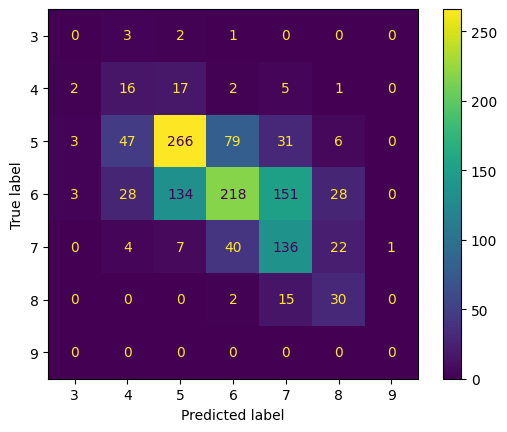

In [66]:
ConfusionMatrixDisplay.from_predictions(y_test_clf, y_pred)
# ConfusionMatrixDisplay.from_predictions(y_test_clf, y_pred)
plt.show()

*Como era de esperar hay bastante poco acierto en general porque hay clases que son tan minoritarias que son idectectables, por ejemplo la calidad 3 es confundida principalmente por un 4 o un 5. La calidad 9 es tan baja que no aparece ni en el test y por tanto tan poco se cuenta, aunque el modeo si que la otorga (a un real 7 que lo puntúa como 9).*

*Cosas a destacar que pueden ayudarnos a mejorar o plantear alternativas:*
*El recall es realtivamente aceptable en la escala central 5 a 8, salvo curiosamente para el 6, donde hay una fuerte bajada.*  

*Para bien la mayoría de los errores son en puntuaciones uno arriba uno abajo (salvo para el 3), lo cual podemos tenerlo en cuenta quizá para ajustar las probabilidades de corte para que se más exigente y así hacer que las clases se separen más.*  

*Otras posibles mejoras:*
- *Simplificar las clases de forma que solo clasifiquemos si los buenos son malos (3 o 4), buenos (5, 6 o 7) o muy buenos (8 o 9).*
- *Hacer un primer clasificador de más de o igual a 6  puntos frente a menos de 6, y luego intentar clasificar más precisamente en un modelo ensamblado siguiente.*
- *También podríamos convertirlo en un problema de regresión y hacer su correspondiente análisis de errores.*  

*Por supuesto, conseguir más datos en los que haya calidades más altas y más bajas también nos ayudaría.*

### #3 Modelado para regresión

Reutiliza todo lo que puedas la preparación del modelado de la parte anterior y construye ahora el mejor modelo que puedas para predecir el grado alcohólico de un vino dadas sus características fisico químicas, su clase y la puntuación de calidad que le ha sido otorgada. Compara al menos tres tipos de modelos, seleccionando una métrica adecuada de comparación y escoge el más apropiado empleando validación cruzada antes o después de optimizar hiperparámetros (en la sesión en vivo lo haremos antes por cuestiones de tiempo). Evalúa el modelo escogido y con los hiperparámetros ajustados de la mejor manera que puedas. Para terminar realizar un pequeño análisis de errores.

*Todo el trabajo está hecho para centrarnos en los modelos y eso vamos a ver empleando además el MAPE como comparativa (porque ninguno tiene 0 como grado alcohólico)*

In [ ]:
rf_reg = RandomForestRegressor(max_depth = 10, random_state= 42)
lgb_reg = LGBMRegressor(max_depth = 10, random_state = 42, verbose = -1)
xgb_reg = XGBRegressor(max_depth = 10, random_state = 42)

modelos_reg = {
    "Random Forest": rf_reg,
    "LightGBM": lgb_reg,
    "XGBoost Regressor": xgb_reg
}

In [68]:
for feature_set, X_train in X_train_reg_dict.items():
    print(f"Para el set {feature_set}:")
    for tipo,modelo in modelos_reg.items():
        print(f"{tipo}: ", end = " ")
        print(-np.mean(cross_val_score(modelo, X_train, y_train_reg, cv = 5, scoring = "neg_mean_absolute_percentage_error"))) # MAPE = 0.024 -> ¿bueno o malo? 2,4% de error! 
    print("******")

Para el set cat+num_1:
Random Forest:  0.03619890459154355
LightGBM:  0.035972036701112875
XGBoost Regressor:  0.03141874374470924
******
Para el set todas:
Random Forest:  0.03071718874172611
LightGBM:  0.02668719056406977
XGBoost Regressor:  0.024489209644827585
******


*Nota: los valores del MAPE en scikit-learn son en rango [0,1] y no [0,100], por lo que un MAPE de 2 significaría un error del 200%*

*Menor MAPE usando todas las features, en este caso nos quedaremos con el RandomForest por simplicidad frente al XGBoost ya que las métricas son muy similares (los errores son practicamente nulos en todos los casos, clavan las predicciones en comparación con el problema de clasificación)*

In [69]:
param_grid = {
    "n_estimators": [100,200,1000],
    "max_depth": [1,5,10,20],
    "max_features": ["log2","sqrt", None]
}

rf_reg = RandomForestRegressor()

rf_grid = GridSearchCV(rf_reg,
                       param_grid= param_grid,
                       cv = 5,
                       scoring = "neg_mean_absolute_percentage_error",
                       n_jobs= -1)

rf_grid.fit(X_train_reg_dict["todas"], y_train_reg)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestRegressor()
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [1, 5, ...], 'max_features': ['log2', 'sqrt', ...], 'n_estimators': [100, 200, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_mean_absolute_percentage_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter

In [70]:
print(rf_grid.best_params_)
print(rf_grid.best_score_)


{'max_depth': 20, 'max_features': None, 'n_estimators': 1000}
-0.026649779352623533


In [71]:
y_pred = rf_grid.best_estimator_.predict(X_test_reg_dict["todas"])
print("MAPE:", mean_absolute_percentage_error(y_test_reg, y_pred))

MAPE: 0.024840720251226637


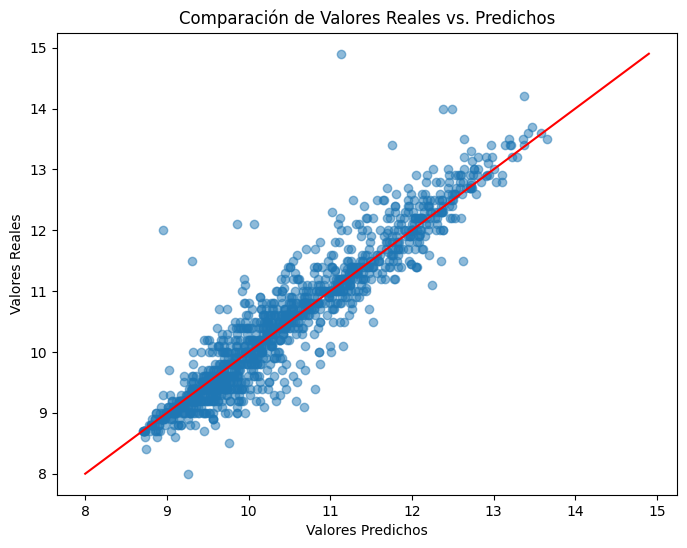

In [72]:
plot_predictions_vs_actual(y_test_reg, y_pred)

#### IMPORTANTE: Si las predicciones os salen perfectas durante el análisis de errores, es decir, todas las predicciones sobre la línea roja. Eso indica que hay un error y siempre hay que desconfiar de los modelos perfectos.

In [73]:
pd.DataFrame({"features": rf_grid.best_estimator_.feature_names_in_ , "importance": rf_grid.best_estimator_.feature_importances_}).sort_values("importance",ascending=False)

,features,importance
2,density,0.603710
3,residual sugar,0.097399
4,total sulfur dioxide,0.052401
5,chlorides,0.038747
0,class,0.038720
7,fixed acidity,0.037300
6,pH,0.029779
9,citric acid,0.028013
10,sulphates,0.022133
8,volatile acidity,0.020177


*Misma pregunta que en el clasificador, ¿la importancia que ha dado el modelo a las features coincide con nuestra previsión inicial?* :-)

#### EXTRA: Guardado del modelo para su reutilización

In [ ]:
import pickle

# Guardar el modelo en un archivo con extensión .pkl
with open('rf_model.pkl', 'wb') as file:
    pickle.dump(rf_grid.best_estimator_, file)


In [75]:
# Cargar el modelo
with open('rf_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [76]:
loaded_model

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",1000
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",None
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [77]:
# joblib es una alternativa a pickle, lo veremos pero podéis investigar :-)